C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

주간test개수:  76
일별test개수:  721
Train on 3609 samples, validate on 903 samples
Epoch 1/10
3609/3609 [==============================] - 14s 4ms/step - loss: 0.0400 - val_loss: 0.0377
Epoch 2/10
3609/3609 [==============================] - 12s 3ms/step - loss: 0.0320 - val_loss: 0.0229
Epoch 3/10
3609/3609 [==============================] - 12s 3ms/step - loss: 0.0280 - val_loss: 0.0461
Epoch 4/10
3609/3609 [==============================] - 12s 3ms/step - loss: 0.0273 - val_loss: 0.0312
Epoch 5/10
3609/3609 [==============================] - 13s 4ms/step - loss: 0.0263 - val_loss: 0.0179
Epoch 6/10
3609/3609 [==============================] - 13s 4ms/step - loss: 0.0256 - val_loss: 0.0236
Epoch 7/10
3609/3609 [==============================] - 13s 4ms/step - loss: 0.0251 - val_loss: 0.0204
Epoch 8/10
3609/3609 [==============================] - 13s 4ms/step - loss: 0.0245 - val_loss: 0.0251
Epoch 9/10
3609/3609 [==============================] - 13s 4ms/step - loss: 0.0239 - val_loss: 0.01

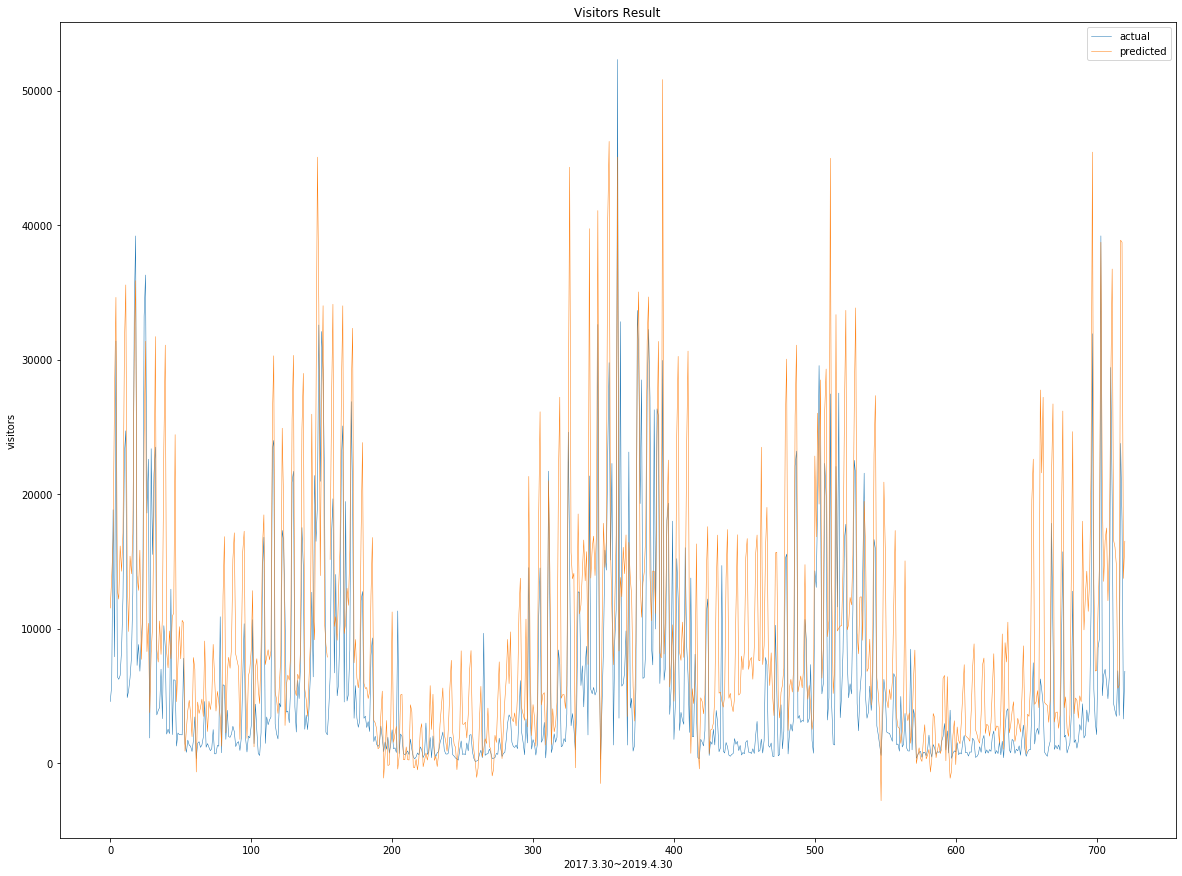

In [3]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2016-12-17'
split_date_start = '2017-3-30'
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)
y_train2LSTM = train_sc_df2LSTM.dropna()[['Scaled']]

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)
y_test2LSTM = test_sc_df2LSTM.dropna()[['Scaled']]
#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTM = X_train2LSTM.values
X_test2LSTM= X_test2LSTM.values

y_train2LSTM = y_train2LSTM.values
y_test2LSTM = y_test2LSTM.values

X_train_t2LSTM = X_train2LSTM.reshape(X_train2LSTM.shape[0], week, 1)
X_test_t2LSTM = X_test2LSTM.reshape(X_test2LSTM.shape[0], week, 1)

print('주간test개수: ', len(y_test2LSTM))
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

train_scLSTM = sc.transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]
#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)

print('일별test개수: ', len(y_testLSTM))
#******************************주단위 LSTM모델링**************************************************
K.clear_session()
model2 = Sequential() 
model2.add(LSTM(60, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(60))
model2.add(Dense(1))
# adam2 = optimizers.Adam(lr=0.0004)
# model2.compile(loss='mean_squared_error', optimizer=adam2) 

# early_stop2 = EarlyStopping(monitor='loss', patience=30, verbose=1)

# model2.fit(X_train_t2LSTM, y_train2LSTM, epochs=2,
#           batch_size=10, verbose=1, callbacks=[early_stop2])
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(56, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(56))
model.add(Dense(10))
# adam = optimizers.Adam(lr=0.001)
# model.compile(loss='mean_squared_error', optimizer=adam)

# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

# model.fit(X_train_tLSTM, y_trainLSTM, epochs=2,
#           batch_size=30, verbose=1, validation_split = 0.2, callbacks=[early_stop])
#***************************************************************************************************

# y_pred2 = model2.predict(X_test_t2LSTM)
# y_pred2train = model2.predict(X_train_t2LSTM)
# plt.plot(y_train2LSTM)
# plt.plot(y_pred2train)
# plt.show()

# y_pred = model.predict(X_test_tLSTM)
# y_predtrain = model.predict(X_train_tLSTM)
# plt.plot(y_testLSTM)
# plt.plot(y_pred)
# plt.show()
#********************************이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환****************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]
    
X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)
y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(500, activation='relu', name='Hidden-2'))
        self.add(layers.Dense(10))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model.output, model3.output])

x = Dense(100)(combinedInput)
x = Dense(100)(x)
x = Dense(1)(x)

model4 = Model(inputs=[model.input, model3.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
X_train_sc_dropped = X_train_sc[dayto-1:]#시계열데이터에 맞게 변환

early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
model4.fit([X_train_tLSTM, X_train_sc_dropped], y_trainLSTM, validation_split = 0.2, epochs=10, batch_size=10, callbacks=[early_stop])

#모델 세이브
from keras.models import save_model
model4.save('thisday1.h5')

X_test_sc_dropped = X_test_sc[dayto-1:]#시계열데이터에 맞게 변환
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel('2017.3.30~2019.4.30')#수정해야 함
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_tLSTM, X_test_sc_dropped])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()

